<a href="https://colab.research.google.com/github/costpetrides/Fluid-Dynamics/blob/main/2D-Flow-Cylinder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Lattice Boltzmann Method

Solving 2D Heat flow around square/circular cylinder

BKG Model
------------------------------------------------

Number of iterations:  10000
Flow Reynolds Number:  5 

Select the geometry: SQUARE CYLINDER or CIRCULAR CYLINDER: SQUARE CYLINDER


 Solving ...
------------------------------------------------


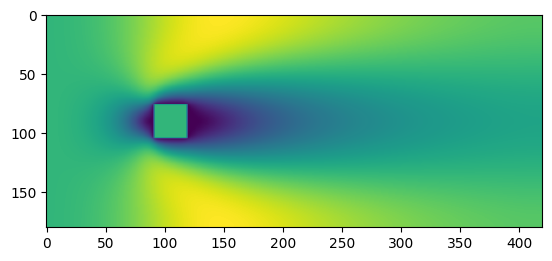

In [2]:
#2D Flow around cylinder

#Lattice Boltzmann BKG Method

from numpy import *
import matplotlib.pyplot as plt
from matplotlib import cm

lineSingle = '------------------------------------------------'
lineDouble = '================================================'

print("\n")
print(lineDouble)
print("Lattice Boltzmann Method\n")
print("Solving 2D Heat flow around square/circular cylinder\n")
print("BKG Model")
print(lineSingle)

#flow defination

iterations = 10000       #total number of time iteration
print("\nNumber of iterations: ",iterations)

Re         = 5          #flow reynolds number
print("Flow Reynolds Number: ",Re,"\n")

nx, ny     = 420, 180    #number of lattice node
ly         = ny-1        #height of the domain

#creating shape of the obstacle: cylinder

cx, cy = nx//4, ny//2             #cylinder coordinates

geometry = ""
while not (geometry == 'SQUARE CYLINDER' or geometry == 'CIRCULAR CYLINDER'):

    geometry = input("Select the geometry: SQUARE CYLINDER or CIRCULAR CYLINDER: ").upper()

def obstacle_cylinder(x,y):

        if geometry == "CIRCULAR CYLINDER":
            r = ny//9                                #circle radius
            return (x-cx)**2 + (y-cy)**2<r**2
        elif geometry == "SQUARE CYLINDER":
            r = ny//6                                #side of square
            return abs((x-cx) + (y-cy)) + abs((x-cx) - (y-cy)) < r

obstacle = fromfunction(obstacle_cylinder, (nx,ny))        #forming the obstacle

if geometry == "CIRCULAR CYLINDER":
    r = ny//9                                #circle radius
elif geometry == "SQUARE CYLINDER":
    r = ny//6                                #side of square

in_velocity = 0.04                #inflow velocity
nu          = in_velocity*r/Re;   #fluid viscoisty
omega       = 1 / (3*nu + 0.5);   #relaxatation parameter


#defining lattice constants

v = array([ [1,1], [1,0], [1,-1], [0,1], [0,0], [0,-1], [-1,1], [-1,0], [-1,-1] ])

t = array([ 1/36, 1/9, 1/36, 1/9, 4/9, 1/9, 1/36, 1/9, 1/36])

col1 = array([0, 1, 2])
col2 = array([3, 4, 5])
col3 = array([6, 7, 8])

#defining macroscopic flow variable

def macroscopic(fin):
    rho = sum(fin, axis = 0)                     #calculating density
    u = zeros((2,nx,ny))                         #calculating velocities
    for i in range(9):
        u[0,:,:] += v[i,0]*fin[i,:,:]
        u[1,:,:] += v[i,1]*fin[i,:,:]
    u /= rho
    return rho, u

# Equilibrium distribution function.

def equilibrium(rho,u):
    usqr = 3/2 * (u[0]**2 + u[1]**2)
    eq = zeros((9,nx,ny))
    for i in range(9):
        cu = 3*(v[i,0]*u[0,:,:] + v[i,1]*u[1,:,:])
        eq[i:,:] = rho*t[i]*(1 + cu + 0.5*cu**2 - usqr)
    return eq

# Initial velocity field: almost zero, with a slight perturbation to trigger the instability.

def init_vel(d,x,y):
    return (1-d) * in_velocity * (1 + 1e-4*sin(y/ly*2*pi))

vel = fromfunction(init_vel, (2,nx,ny))

# Initialization of the populations at equilibrium with the given velocity.

fin = equilibrium(1, vel)

print("\n")
print(lineDouble)
print(' Solving ...')
print(lineSingle)

#Time Loop

for time in range(iterations):

    fin[col3,-1,:] = fin[col3,-2,:]        #outflow BC

    rho, u = macroscopic(fin)              #compute velocity & density

    u[:,0,:] = vel[:,0,:]                  #inflow BC
    rho[0,:] = 1/(1-u[0,0,:])*(sum(fin[col2,0,:],axis=0) + 2*(sum(fin[col3,0,:],axis=0)))

    #compute the population & equilibrium
    feq = equilibrium(rho,u)
    fin[[0,1,2],0,:] = feq[[0,1,2],0,:] + fin[[8,7,6],0,:] - feq[[8,7,6],0,:]

    #collision Step

    fout = fin - omega * (fin - feq)

    #No slip/Bounce Back Condition for the cylinder wall

    for i in range(9):
        fout[i,obstacle] = fin[8-i,obstacle]

    #Streaming Step

    for i in range(9):
        fin[i,:,:] = roll(roll(fout[i,:,:], v[i,0], axis=0), v[i,1], axis=1)

    #Visualization of the velocity field

    if (time%100==0):
        plt.clf()
        plt.imshow(sqrt(u[0]**2+u[1]**2).transpose(), cmap=cm.viridis)
        plt.savefig("vel.{0:04d}.png".format(time//100),dpi=600)